Problem Statement 
 
Use NYC Green Taxi data to implement a machine learning system to predict the expected tip amount for a trip.

Data 
 
2017 GYC Green Taxi Data: https://data.cityofnewyork.us/browse?q=2017%20Green%20Taxi%20Trip%20Data&sortBy= relevance 
 
I am using the Jan 2017 data for the model training (train set) and Feb 2017 data for model evaluation (test set). The code is fully written in python. In order to build the final model, four phases were followed, namely (1) data cleaning, (2) feature engineering (3) exploratory data analysis and (4) model creation. 

Starting with loading required packages.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import os, json, requests, pickle
from scipy.stats import skew
from scipy.stats import ttest_ind, f_oneway, lognorm, levy, skew, chisquare
#import scipy.stats as st
from sklearn.preprocessing import normalize, scale
from tabulate import tabulate
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

I have downloaded the data (pickup date range from 01/01/2017 to 28/02/2017), saved in the local folder. Let's load the file and see the size of it.

In [2]:
data=pd.read_csv("C:/Users/Toshiba/Downloads/2017_Green_Taxi_Trip_Data (1).csv")

# Print the size of the dataset
print ("Number of rows:", data.shape[0])
print ("Number of columns: ", data.shape[1])

Number of rows: 2061570
Number of columns:  19


In [3]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
VendorID,2061570.0,1.797491,0.401870,1.00,2.00,2.00,2.00,2.00
RatecodeID,2061570.0,1.082599,0.564157,1.00,1.00,1.00,1.00,99.00
PULocationID,2061570.0,112.855765,76.570138,1.00,49.00,82.00,168.00,265.00
DOLocationID,2061570.0,129.156050,77.537264,1.00,61.00,129.00,193.00,265.00
passenger_count,2061570.0,1.366024,1.041964,0.00,1.00,1.00,1.00,9.00
trip_distance,2061570.0,2.583256,2.707952,0.00,0.98,1.69,3.20,171.65
fare_amount,2061570.0,11.309419,8.941667,-218.08,6.00,8.50,13.50,1209.00
extra,2061570.0,0.356919,0.385910,-4.50,0.00,0.50,0.50,4.50
mta_tax,2061570.0,0.487314,0.085009,-0.50,0.50,0.50,0.50,0.81
tip_amount,2061570.0,1.140385,2.166117,-101.00,0.00,0.00,1.95,303.00


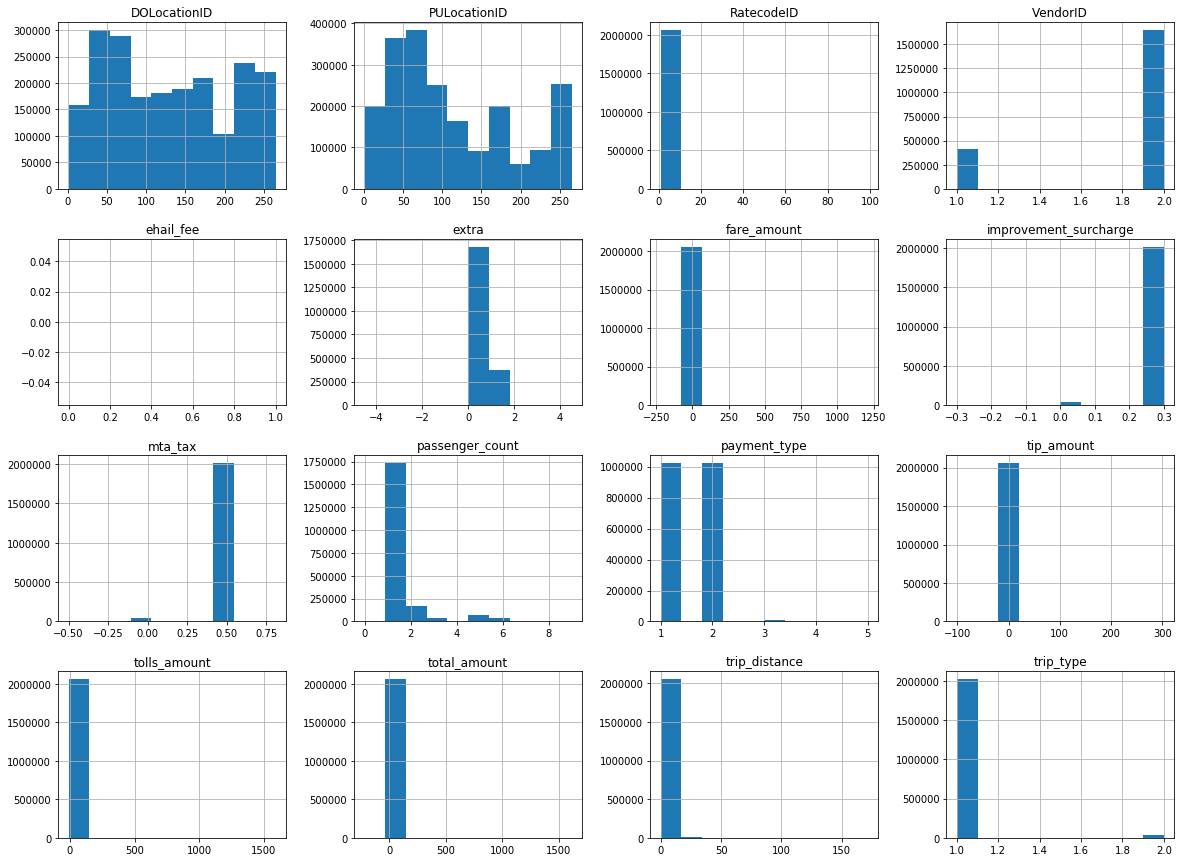

In [4]:
data.hist(figsize=(20,15))
plt.show()

The initial dataset contained 2061570 transactions with 19 variables. 

ehail_fee was removed since majority of the data are missing.
Invalid data (Negative values) found in 1.RatecodeID (value=99) 2.extra 3.total_amount 4.fare_amount 5.improvement surcharge 6.tip_amount.
Idea is to replace all invalid data in numerical variables by their absolute values and all categorical features replaced by its most common value.
Additionally the minimum total_amount is $2.5, and every transaction falling below that amount was replaced by the median value of the total_amount $10.8.
Time stamp variables need to be converted to right format.


In [5]:
# define a function to clean  dataset

def clean_data(adata):
    
    ## make a copy of the input
    data = adata.copy()
    if 'ehail_fee' in data.columns:
        data.drop('ehail_fee',axis=1,inplace=True)

    
    print ("Negative values found and replaced by their abs")
    print ("Total_amount", 100*data[data.total_amount<0].shape[0]/float(data.shape[0]),"%")
    print ("Fare_amount", 100*data[data.fare_amount<0].shape[0]/float(data.shape[0]),"%")
    print ("Improvement_surcharge", 100*data[data.improvement_surcharge<0].shape[0]/float(data.shape[0]),"%")
    print ("Tip_amount", 100*data[data.tip_amount<0].shape[0]/float(data.shape[0]),"%")
    print ("Tolls_amount", 100*data[data.tolls_amount<0].shape[0]/float(data.shape[0]),"%")
    print ("MTA_tax", 100*data[data.mta_tax<0].shape[0]/float(data.shape[0]),"%")
    data.total_amount = data.total_amount.abs()
    data.fare_amount = data.fare_amount.abs()
    data.improvement_surcharge = data.improvement_surcharge.abs()
    data.tip_amount = data.tip_amount.abs()
    data.tolls_amount = data.tolls_amount.abs()
    data.mta_tax = data.mta_tax.abs()
    data.extra=data.extra.abs()
    # RatecodeID
    indices_oi = data[~((data.RatecodeID>=1) & (data.RatecodeID<=6))].index
    data.loc[indices_oi, 'RatecodeID'] = 1 # 1 was identified as the common method
    print (round(100*len(indices_oi)/float(data.shape[0]),2),"% of values in RateCodeID were invalid.--> Replaced by the most frequent 1")
    
    # Total_amount: the minimum charge is 2.5, so I will replace every thing less than 2.5 by the median 11.76 (pre-obtained in analysis)
    indices_oi = data[(data.total_amount<2.5)].index
    data.loc[indices_oi,'total_amount'] = 10.8
    print (round(100*len(indices_oi)/float(data.shape[0]),2),"% of values in total amount worth <$2.5.--> Replaced by the median 10.8")
    
      
    # rename time stamp variables and convert them to the right format
    
    print ("renaming variables...")
    data.rename(columns={'lpep_pickup_datetime':'Pickup_dt','lpep_dropoff_datetime':'Dropoff_dt'},inplace=True)
    print ("converting timestamps variables to right format ...")
    # First, convert pickup and drop off datetime variable in their specific righ format
    data['Pickup_dt'] = data.Pickup_dt.apply(lambda x:dt.datetime.strptime(x,'%m/%d/%Y %I:%M:%S %p'))
    data['Dropoff_dt'] = data.Dropoff_dt.apply(lambda x:dt.datetime.strptime(x,'%m/%d/%Y %I:%M:%S %p'))
    
    
      
    print ("Done cleaning")
    return data

In [6]:
# Run code to clean the data
data = clean_data(data)

Negative values found and replaced by their abs
Total_amount 0.22487715673006495 %
Fare_amount 0.22487715673006495 %
Improvement_surcharge 0.21226540937246854 %
Tip_amount 0.002134295706670159 %
Tolls_amount 9.701344121227996e-05 %
MTA_tax 0.2088214322094326 %
0.0 % of values in RateCodeID were invalid.--> Replaced by the most frequent 1
0.27 % of values in total amount worth <$2.5.--> Replaced by the median 10.8
renaming variables...
converting timestamps variables to right format ...
Done cleaning


In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
VendorID,2061570.0,1.797491,0.401870,1.0,2.00,2.00,2.00,2.00
RatecodeID,2061570.0,1.082551,0.560020,1.0,1.00,1.00,1.00,6.00
PULocationID,2061570.0,112.855765,76.570138,1.0,49.00,82.00,168.00,265.00
DOLocationID,2061570.0,129.156050,77.537264,1.0,61.00,129.00,193.00,265.00
passenger_count,2061570.0,1.366024,1.041964,0.0,1.00,1.00,1.00,9.00
trip_distance,2061570.0,2.583256,2.707952,0.0,0.98,1.69,3.20,171.65
fare_amount,2061570.0,11.346344,8.894765,0.0,6.00,8.50,13.50,1209.00
extra,2061570.0,0.358537,0.384408,0.0,0.00,0.50,0.50,4.50
mta_tax,2061570.0,0.489402,0.072021,0.0,0.50,0.50,0.50,0.81
tip_amount,2061570.0,1.140647,2.165979,0.0,0.00,0.00,1.95,303.00


Time variables: Week_day (Day of week), Hour (hour of day) added as additional features.
Trip_duration : time difference between dropoff and pickup time
Speed: The ratio of Trip_distance to Trip_duration.
With_tip: Transactions with tips or not.


In [8]:
def engineer_features(adata):
     # make copy of the original dataset
    data = adata.copy()
    # derive time variables
    print ("deriving time variables...")
    data['Week_day']  = data.Pickup_dt.apply(lambda x:x.isocalendar()[2])
    data['Hour'] = data.Pickup_dt.apply(lambda x:x.hour)

    # Trip duration 
    print ("deriving Trip_duration...")
    data['trip_duration'] = ((data.Dropoff_dt-data.Pickup_dt).apply(lambda x:x.total_seconds()/60.))


    # create variable for Speed
    print ("deriving Speed. Make sure to check for possible NaNs and Inf vals...")
    data['speed_mph'] = data.trip_distance/(data.trip_duration/60)
    # replace all NaNs values and values >240mph by a values sampled from a random distribution of 
    # mean 12.9 and  standard deviation 6.8mph. These values were extracted from the distribution
    indices_oi = data[(data.speed_mph.isnull()) | (data.speed_mph>240)].index
    data.loc[indices_oi,'speed_mph'] = np.abs(np.random.normal(loc=12.9,scale=6.8,size=len(indices_oi)))
    print ("Feature engineering done! :-)")


    # create with_tip variable
    data['With_tip'] = (data.tip_amount>0)*1

    return data




Converting data type to 'category' for the relevant columns followed by converting categorical columns to binary columns (one-hot encoding) to make it compatible for the scikit learn models.

In [9]:
data = engineer_features(data)
# Iterate through the columns
for col in list(data.columns):
    # Select columns that need to be category 
    if ('trip_type' in col or 'payment_type' in col or 'With_tip' in col or 'RatecodeID' in col
       or 'VendorID' in col or 'store_and_fwd_flag' in col):
        # Convert the data type to category
        data[col] = data[col].astype('category')

categorical_subset = data[['With_tip','payment_type','trip_type','RatecodeID','VendorID','store_and_fwd_flag']]
rest= [col for col in data.columns if col not in categorical_subset]
rest_subset=data[rest]

# One hot encode
categorical_subset = pd.get_dummies(categorical_subset)

# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
features = pd.concat([rest_subset, categorical_subset], axis = 1)

deriving time variables...
deriving Trip_duration...
deriving Speed. Make sure to check for possible NaNs and Inf vals...
Feature engineering done! :-)


In [10]:
corr_matrix = features.corr()
corr_matrix["tip_amount"].sort_values(ascending=False)

tip_amount               1.000000
With_tip_1               0.617158
total_amount             0.559262
payment_type_1           0.530765
fare_amount              0.388673
trip_distance            0.386331
speed_mph                0.145216
RatecodeID_2             0.077381
tolls_amount             0.068359
DOLocationID             0.057299
RatecodeID_3             0.049600
PULocationID             0.034848
RatecodeID_4             0.031891
trip_duration            0.019785
improvement_surcharge    0.017711
trip_type_1              0.016692
Week_day                 0.011632
mta_tax                  0.010021
extra                    0.006059
passenger_count          0.004087
store_and_fwd_flag_N     0.001723
VendorID_1               0.000933
VendorID_2              -0.000933
store_and_fwd_flag_Y    -0.001723
RatecodeID_6            -0.001906
payment_type_5          -0.003441
RatecodeID_5            -0.015306
Hour                    -0.016612
trip_type_2             -0.016692
RatecodeID_1  

Next, each variable distribution and its relationship with the Tip were explored. Few functions were implemented to quickly explore those variables:

In [11]:
# Functions for exploratory data analysis
def visualize_continuous(df,label,method={'type':'histogram','bins':20},outlier='off'):
    """
    function to quickly visualize continous variables
    df: pandas.dataFrame 
    label: str, name of the variable to be plotted. It should be present in df.columns
    method: dict, contains info of the type of plot to generate. It can be histogram or boxplot [-Not yet developped]
    outlier: {'on','off'}, Set it to off if you need to cut off outliers. Outliers are all those points
    located at 3 standard deviations further from the mean
    """
    # create vector of the variable of interest
    v = df[label]
    # define mean and standard deviation
    m = v.mean()
    s = v.std()
    # prep the figure
    fig,ax = plt.subplots(1,2,figsize=(14,4))
    ax[0].set_title('Distribution of '+label)
    ax[1].set_title('tip_amount by '+label)
    if outlier=='off': # remove outliers accordingly and update titles
        v = v[(v-m)<=3*s]
        ax[0].set_title('Distribution of '+label+'(no outliers)')
        ax[1].set_title('Tip by '+label+'(no outliers)')
    if method['type'] == 'histogram': # plot the histogram
        v.hist(bins = method['bins'],ax=ax[0])
    if method['type'] == 'boxplot': # plot the box plot
        df.loc[v.index].boxplot(label,ax=ax[0])
    ax[1].plot(v,df.loc[v.index].tip_amount,'.',alpha=0.4)
    ax[0].set_xlabel(label)
    ax[1].set_xlabel(label)
    ax[0].set_ylabel('Count')
    ax[1].set_ylabel('tip')

def visualize_categories(df,catName,chart_type='histogram',ylimit=[None,None]):
    """
    This functions helps to quickly visualize categorical variables. 
    This functions calls other functions generate_boxplot and generate_histogram
    df: pandas.Dataframe
    catName: str, variable name, it must be present in df
    chart_type: {histogram,boxplot}, choose which type of chart to plot
    ylim: tuple, list. Valid if chart_type is histogram
    """
    print (catName)
    cats = sorted(pd.unique(df[catName]))
    if chart_type == 'boxplot': #generate boxplot
        generate_boxplot(df,catName,ylimit)
    elif chart_type == 'histogram': # generate histogram
        generate_histogram(df,catName)
    else:
        pass
    

def generate_boxplot(df,catName,ylimit):
    """
    generate boxplot of tip percentage by variable "catName" with ylim set to ylimit
    df: pandas.Dataframe
    catName: str
    ylimit: tuple, list
    """
    df.boxplot('tip_amount',by=catName)
    #plt.title('Tip by '+catName)
    plt.title('')
    plt.ylabel('Tip')
    if ylimit != [None,None]:
        plt.ylim(ylimit)
    plt.show()

def generate_histogram(df,catName):
    """
    generate histogram of tip by variable "catName" with ylim set to ylimit
    df: pandas.Dataframe
    catName: str
    ylimit: tuple, list
    """
    cats = sorted(pd.unique(df[catName]))
    colors = plt.cm.jet(np.linspace(0,1,len(cats)))
    hx = np.array(map(lambda x:round(x,1),np.histogram(df.tip_amount,bins=20)[1]))
    fig,ax = plt.subplots(1,1,figsize = (15,4))
    for i,cat in enumerate(cats):
        vals = df[df[catName] == cat].tip_amount
        h = np.histogram(vals,bins=hx)
        w = 0.9*(hx[1]-hx[0])/float(len(cats))
        plt.bar(hx[:-1]+w*i,h[0],color=colors[i],width=w)
    plt.legend(cats)
    plt.yscale('log')
    plt.title('Distribution of Tip by '+catName)
    plt.xlabel('Tip')

Listing some of the distributions

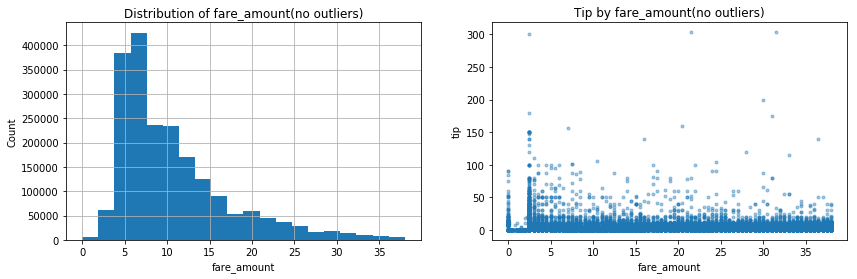

In [12]:
visualize_continuous(data,'fare_amount',outlier='off')

payment_type


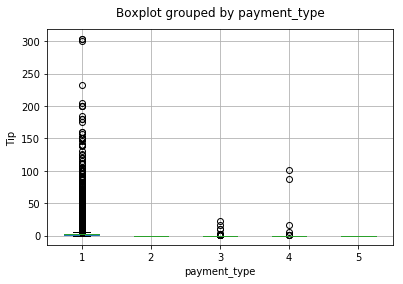

In [13]:
visualize_categories(data,'payment_type',chart_type='boxplot')


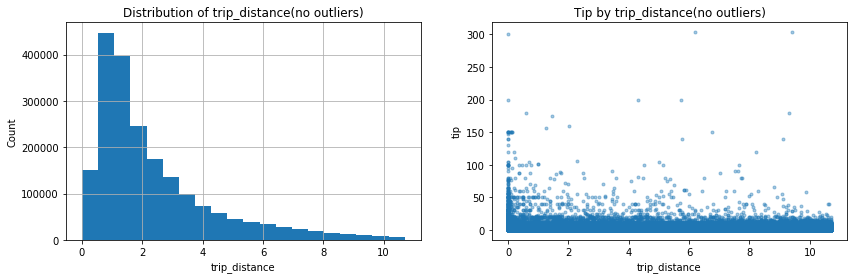

In [14]:
visualize_continuous(data,'trip_distance',outlier='off')

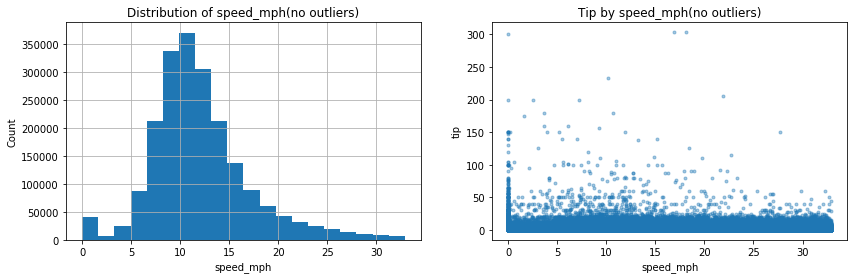

In [15]:
visualize_continuous(data,'speed_mph',outlier='off')

Separate out the features and target (tip_amount) and split the data into training (Jan 2017) and test set (Feb 2017)

In [16]:

features = features.drop(columns=['tip_amount','Pickup_dt','Dropoff_dt'])
targets = pd.DataFrame(data['tip_amount'])

In [17]:
split_date = pd.datetime(2017,2,1)

X = features.loc[data['Pickup_dt'] < split_date]
y=targets.loc[data['Pickup_dt'] < split_date]
X_test = features.loc[data['Pickup_dt'] >= split_date]
y_test=targets.loc[data['Pickup_dt'] >= split_date]

In [18]:
print(X.shape)
print(X_test.shape)
print(y.shape)
print(y_test.shape)

(1070261, 33)
(991309, 33)
(1070261, 1)
(991309, 1)


In [19]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score


In [20]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X,y)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

print('Intercept: \n', regr.intercept_)
# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('R-squared value: %.2f' % r2_score(y_test, y_pred))

Intercept: 
 [-3.26100607]
Coefficients: 
 [[-6.70337256e-06  2.52825931e-06 -2.44230496e-03 -5.62403189e-02
  -8.32697043e-01 -8.24655363e-01  9.63412121e+00 -8.30653064e-01
   3.16593437e+00  8.59468477e-01  3.24859619e-03  3.14957401e-04
   2.49670293e-05  5.23970357e-03 -1.58334838e-01  1.58334838e-01
   1.07447027e-01  1.26733342e-01 -1.48083746e-01  8.45438513e-02
  -1.70640474e-01 -2.59225197e+00  2.59225197e+00 -8.06480443e-01
  -1.15114185e+00  4.21482263e+00 -1.20259366e+00 -5.76713033e-01
  -4.77893647e-01 -1.32722817e-02  1.32722817e-02 -1.96939211e-02
   1.96939211e-02]]
Mean squared error: 0.31
R-squared value: 0.94


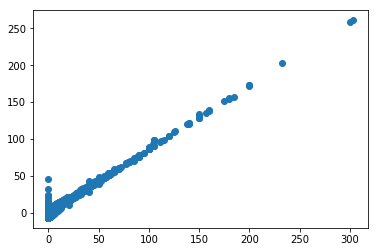

In [21]:
plt.scatter(y_test,y_pred)

Conclusion:

1.Results are pretty good with 94% variance explained by the linear regression model.
2.Predicted tip_amount has values <0 , which need to be deduced as no tip or tip amount = 0.
3.There's more scope in improving the model performance by trying SVM,GBM or an ensemble model which need to be checked, but limiting here due to time constraint.

